<a href="https://colab.research.google.com/github/gaixen/BCS_recruitment/blob/main/Are%20You%20Bored%20Yet%3F/demo_solution_10sessions_combined(CSHL_001).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation and configuration of dependencies

In [147]:
!pip install --quiet ONE-api
!pip install --quiet ibllib

In [148]:
from one.api import ONE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


# Data Loading and Subject Selection

In [149]:
datasets = one.alyx.rest('datasets', 'list', tag='2021_Q1_IBL_et_al_Behaviour', name='_ibl_subjectTrials.table.pqt')
subjects = np.unique([d['file_records'][0]['relative_path'].split('/')[2] for d in datasets])
#Load in the subjectTrials table and sessionTrials table for the first subject
subject = subjects[0]
subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')
session_trials = one.load_aggregate('subjects', subject, '_ibl_subjectSessions.table')
#Add in lab, task_protocol, subject name information from the sessions table
if 'task_protocol' in subject_trials:
    subject_trials = subject_trials.drop('task_protocol', axis=1)
subject_trials = subject_trials.set_index('session').join(session_trials.drop('date', axis=1))

The `subject_trials` table contains all the trials data for each training session collected in the subject. See [here](https://www.google.com/url?q=https%3A%2F%2Fdocs.google.com%2Fdocument%2Fd%2F1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg%2Fedit%23heading%3Dh.ls81qq9ihg4x) for more information about this dataset.

In [150]:
# Find the number of sessions for this subject
n_sessions = subject_trials.index.unique().size
print(f'Subject {subject} has {n_sessions} sessions')
# Find the number of times a task protocol was run
n_protocols = subject_trials[~subject_trials.index.duplicated()].task_protocol.value_counts()
print(n_protocols)

Subject CSHL045 has 76 sessions
task_protocol
_iblrig_tasks_biasedChoiceWorld6.3.1      17
_iblrig_tasks_trainingChoiceWorld6.1.3    14
_iblrig_tasks_trainingChoiceWorld6.2.5    12
_iblrig_tasks_trainingChoiceWorld6.3.1    11
_iblrig_tasks_biasedChoiceWorld6.2.5       6
_iblrig_tasks_ephysChoiceWorld6.2.5        3
_iblrig_tasks_trainingChoiceWorld6.2.4     3
_iblrig_tasks_trainingChoiceWorld6.0.6     3
_iblrig_tasks_trainingChoiceWorld6.2.1     2
_iblrig_tasks_ephysChoiceWorld6.4.0        2
_iblrig_tasks_trainingChoiceWorld6.2.0     1
_iblrig_tasks_trainingChoiceWorld6.1.1     1
_iblrig_tasks_trainingChoiceWorld6.1.2     1
Name: count, dtype: int64


We can get the trials data for an individual session of choice, here a the first session using the `biasedChoiceWorld` protocol

In [151]:
# Get the trials data for a single session
# Find a session run under biasedChoiceWorld
sess = subject_trials[subject_trials['task_protocol'].str.contains('biasedChoiceWorld')].index.unique()[0]
trials = subject_trials[subject_trials.index == sess]

In [152]:
print(session_trials.columns)

Index(['lab', 'subject', 'date', 'number', 'task_protocol', 'projects'], dtype='object')


In [153]:
# #get all known subjects
# subjects=one.alyx.rest('subjects','list')
# #loop to find a subject with biasedChoiceWorld sessions
# valid_subject = None
# valid_eids = []
# # subjects_df=pd.DataFrame()
# for s in subjects:
#     nickname = s['nickname']
#     try:
#         eids = one.search(subject=nickname, task_protocol='biasedChoiceWorld')
#         if len(eids) > 0:
#             valid_subject = nickname
#             valid_eids = eids
#             # subjects_df=subjects_df.append({'subject': nickname}, ignore_index=True)
#             # subjects_df=subjects_df.append({'subject':len(eids)},ignore_index=True)
#             print(f"available subject:{nickname} with {len(eids)} biasedChoiceWorld session(s)")
#             break  # stop after finding one valid subject
#     except:
#         continue
# #combining them in a table

In [154]:
one = ONE()
all_sessions = []
subjects = one.alyx.rest('subjects', 'list')
valid_subject = None
valid_eids = []
for s in subjects:
    nickname = s['nickname']
    try:
        eids = one.search(subject=nickname, task_protocol='biasedChoiceWorld')
        if len(eids) >= 10:
            valid_subject = nickname
            valid_eids = eids[:10]  #taking first 10 sessions only
            print(f"found subject: {nickname} with {len(valid_eids)} sessions.")
            break  #stop after finding the first subject
    except Exception as e:
        print("error")
        continue
#loading trials for first 10 sessions for the chosen subject
if valid_subject:
    for eid in valid_eids:
        try:
            trials = one.load_object(eid, 'trials')
            #filter out multi-dimensional arrays
            flat_trials = {
                k: v for k, v in trials.items()
                if isinstance(v, np.ndarray) and v.ndim == 1
            }
            df = pd.DataFrame(flat_trials)
            df['session_id'] = str(eid)
            df['subject'] = valid_subject
            all_sessions.append(df)
            print(f"Loaded session {eid}")
        except Exception as e:
            print("error")
else:
    print("subject not found")

found subject: CSHL_001 with 10 sessions.
Loaded session 81f9aa32-c0a0-489d-8a3f-d5cf8a94b777
Loaded session 59029ae8-af64-4da7-a172-3e7e49b306f7
Loaded session daacfe62-ce8f-4304-8154-981df72ee52f
Loaded session 0a6a537a-cb16-4bac-8a44-a96248247a79
Loaded session 124c22b6-8fa1-460f-a36b-708501d825ac
Loaded session 817cc288-bb6e-467c-ba34-ab13d6180f26
Loaded session 3b015bd1-08ef-4ca7-acf9-15183eabdb1b
Loaded session 26d3b621-1279-4a3a-a182-fcc863bc5db1
Loaded session 4865b2c8-cc10-47d6-baee-4d500800d27a
Loaded session a45d87f7-aae1-4609-b982-175f4ecaf388


In [155]:
# --- Combine all into a single DataFrame ---
if all_sessions:
    df_all_sess = pd.concat(all_sessions, ignore_index=True)
    print(f"✅ Combined {len(all_sessions)} sessions into df_all with shape: {df_all_sess.shape}")
else:
    print("...")


✅ Combined 10 sessions into df_all with shape: (5455, 13)


In [156]:
if valid_eids:
    eid = valid_eids[0]
# Load trial data
trials = one.load_object(eid, 'trials')
# Show available trial data keys
print("trial data keys:", trials.keys())


trial data keys: dict_keys(['feedbackType', 'contrastRight', 'choice', 'probabilityLeft', 'rewardVolume', 'goCue_times', 'stimOn_times', 'feedback_times', 'response_times', 'firstMovement_times', 'contrastLeft', 'intervals'])


# Feature Engineering and Visualisation

In [157]:
trials_1d = {k: v for k, v in trials.items() if isinstance(v, (list, np.ndarray)) and np.array(v).ndim == 1}
#convert trials_1d to dataframe
df_all_sess = pd.DataFrame(trials_1d)
df_all_sess['session_id'] = eid
#show first few rows
df_all_sess.head()

,feedbackType,contrastRight,choice,probabilityLeft,rewardVolume,goCue_times,stimOn_times,feedback_times,response_times,firstMovement_times,contrastLeft,session_id
0,-1.0,NaN,-1.0,0.5,0.0,1.6922,NaN,NaN,16.3270,NaN,0.0625,81f9aa32-c0a0-489d-8a3f-d5cf8a94b777
1,-1.0,0.25,1.0,0.5,0.0,20.0662,NaN,NaN,35.9022,NaN,NaN,81f9aa32-c0a0-489d-8a3f-d5cf8a94b777
2,-1.0,0.00,1.0,0.5,0.0,39.7385,NaN,NaN,47.0627,NaN,NaN,81f9aa32-c0a0-489d-8a3f-d5cf8a94b777
3,-1.0,NaN,-1.0,0.5,0.0,50.5550,NaN,NaN,50.8648,NaN,0.0625,81f9aa32-c0a0-489d-8a3f-d5cf8a94b777
4,1.0,NaN,1.0,0.5,1.5,54.3064,NaN,70.1632,70.1632,69.7623,0.1250,81f9aa32-c0a0-489d-8a3f-d5cf8a94b777


In [158]:
df_all_sess['reaction_time']=df_all_sess['response_times']-df_all_sess['goCue_times']
df_all_sess['skipped']=df_all_sess['reaction_time'].isna()
df_all_sess['correct'] = (df_all_sess['feedbackType'] == 1).astype(int)
df_all_sess['MA_reaction_time']=df_all_sess['correct'].rolling(window=10, min_periods=1).mean()
choice_map = {1: 1, 0: 0.5, -1: 0}
df_all_sess['choice_mapped'] = df_all_sess['choice'].map(choice_map)
df_all_sess['rolling_choice_bias'] = df_all_sess['choice_mapped'].rolling(window=10, min_periods=1).mean()
df_all_sess['reaction_time_smoothed'] = df_all_sess.groupby('session_id')['reaction_time'].transform(
    lambda x: x.rolling(window=10, min_periods=1).mean()
)
df_all_sess['skip_rate_smoothed'] = df_all_sess.groupby('session_id')['skipped'].transform(
    lambda x: x.rolling(window=10, min_periods=1).mean()
)
df_all_sess['skip_rate_smoothed'] = df_all_sess['skip_rate_smoothed'].astype(int)
df_all_sess['rolling_accuracy'] = df_all_sess.groupby('session_id')['correct'].transform(
    lambda x: x.rolling(window=10, min_periods=1).mean()
)

#df_all_sess['trial_block'] = df_all_sess['trial_num'] // 50
if 'intervals' in trials and np.array(trials['intervals']).ndim == 2:
    intervals = trials['intervals']
    df_all_sess['intervals'] = list(intervals)
    df_all_sess['trial_start'] = intervals[:, 0]
    df_all_sess['trial_end'] = intervals[:, 1]
    df_all_sess['trial_duration'] = trials['intervals'][:, 1] - trials['intervals'][:, 0]
else:
    print("data not available")
df_all_sess['inter_trial_interval'] = df_all_sess.groupby('session_id')['intervals'].transform(
    lambda x: np.insert(np.diff([i[0] for i in x]), 0, np.nan)
)
df_all_sess.drop(columns=['choice_mapped'], inplace=True)
df_all_sess['inter_trial_interval'][0]=df_all_sess['inter_trial_interval'].mean()

<ipython-input-158-ad1391e01f62>:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_all_sess['inter_trial_interval'][0]=df_all_sess['inter_trial_interval'].mean()
<ipython-input-158-ad1391e01f62>:32: SettingWithCopyWarning: 
A value is try

In [159]:
df_all_sess.head()

,feedbackType,contrastRight,choice,probabilityLeft,rewardVolume,goCue_times,stimOn_times,feedback_times,response_times,firstMovement_times,...,MA_reaction_time,rolling_choice_bias,reaction_time_smoothed,skip_rate_smoothed,rolling_accuracy,intervals,trial_start,trial_end,trial_duration,inter_trial_interval
0,-1.0,NaN,-1.0,0.5,0.0,1.6922,NaN,NaN,16.3270,NaN,...,0.0,0.000000,14.634800,0,0.0,"[0.0, 18.827002]",0.0000,18.827002,18.827002,6.085565
1,-1.0,0.25,1.0,0.5,0.0,20.0662,NaN,NaN,35.9022,NaN,...,0.0,0.500000,15.235400,0,0.0,"[19.3521, 38.402203]",19.3521,38.402203,19.050103,19.352100
2,-1.0,0.00,1.0,0.5,0.0,39.7385,NaN,NaN,47.0627,NaN,...,0.0,0.666667,12.598333,0,0.0,"[38.9466, 49.562701999999994]",38.9466,49.562702,10.616102,19.594500
3,-1.0,NaN,-1.0,0.5,0.0,50.5550,NaN,NaN,50.8648,NaN,...,0.0,0.500000,9.526200,0,0.0,"[50.0203, 53.364802]",50.0203,53.364802,3.344502,11.073700
4,1.0,NaN,1.0,0.5,1.5,54.3064,NaN,70.1632,70.1632,69.7623,...,0.2,0.600000,10.792320,0,0.2,"[53.7649, 71.663202]",53.7649,71.663202,17.898302,3.744600


# Boredom score computation and plotting


**Hypertuning the parameters**


---





In [160]:
w1=1.0 #more than 0
w2=1.0 #more than 0
w3=1.0 #more than 0
w4=1.0 #more than 0
w5=1.0 #more than 0

Calculating Boredom Scores

---



In [161]:
df_all_sess['boredom_score'] = (w1*df_all_sess['reaction_time_smoothed'] +w2*(1 - df_all_sess['rolling_accuracy']) + w3*df_all_sess['trial_duration']+w4*df_all_sess['skip_rate_smoothed'])
df_all_sess['boredom_score'].head()

,boredom_score
0,34.461802
1,35.285503
2,24.214435
3,13.870702
4,29.490622


Attempt to make it continuous

---



In [162]:
from sklearn.preprocessing import MinMaxScaler
features = ['reaction_time_smoothed','skip_rate_smoothed','trial_duration']
#rolling accuracy increase suggests low boredom index
df_all_sess['inaccuracy'] = 1 - df_all_sess['rolling_accuracy']
#replacing inf/nan with 0 for safe scaling
df_all_sess[features + ['inaccuracy']] = df_all_sess[features + ['inaccuracy']].replace([np.inf, -np.inf], np.nan).fillna(0)
#normalizing the session
df_all_sess_norm = df_all_sess.copy()
for session_id in df_all_sess['session_id'].unique():
    session_mask = df_all_sess['session_id'] == session_id
    scaler = MinMaxScaler()
    df_all_sess_norm.loc[session_mask, ['reaction_time_smoothed', 'skip_rate_smoothed','trial_duration', 'inaccuracy']] = scaler.fit_transform(df_all_sess.loc[session_mask, ['reaction_time_smoothed', 'skip_rate_smoothed','trial_duration','inaccuracy']])

In [163]:
df_all_sess_norm['boredom_score'] = (w1* df_all_sess_norm['reaction_time_smoothed'] +w4* df_all_sess_norm['skip_rate_smoothed'] +w3* df_all_sess_norm['trial_duration']+w2* df_all_sess_norm['inaccuracy'])

In [164]:
df_all_sess_norm['boredom_score_smoothed'] = df_all_sess_norm.groupby('session_id')['boredom_score'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
df_all_sess_norm['trial_num'] = df_all_sess_norm.groupby('session_id').cumcount()

In [165]:
df_all_sess_norm.head()
df_all_sess_norm['rolling_accuracy'].head(20)

,rolling_accuracy
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.200000
5,0.333333
6,0.428571
7,0.500000
8,0.444444
9,0.400000


***Creating a plot of continuous boredom score***

---



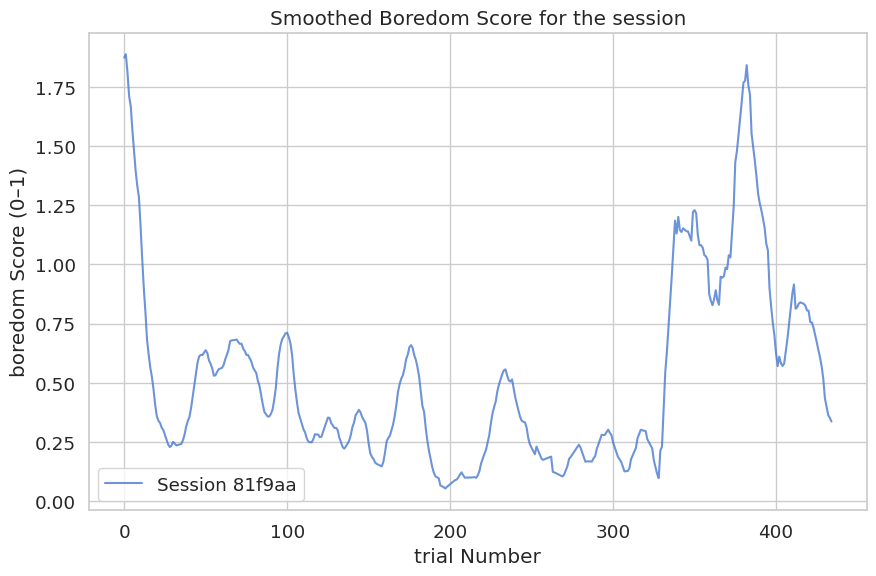

In [166]:
sample_sess = df_all_sess_norm['session_id'].unique()[:3]
#set the style
sns.set(style="whitegrid",palette="muted",font_scale=1.2)
#plot each session's boredom score over trial number
plt.figure(figsize=(9,6))
for session_id in sample_sess:
    session_df = df_all_sess_norm[df_all_sess_norm['session_id'] == session_id]
    plt.plot(session_df['trial_num'], session_df['boredom_score_smoothed'], label=f"Session {str(session_id)[:6]}", alpha=0.8)
plt.title("Smoothed Boredom Score for the session")
plt.xlabel("trial Number")
plt.ylabel("boredom Score (0–1)")
plt.legend()
plt.tight_layout()
plt.show()

# Model architecture and training

In [167]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [168]:
#features to use
feature_cols = ['reaction_time_smoothed','rolling_accuracy','skip_rate_smoothed','trial_duration']
target_col = 'boredom_score'

In [169]:
# # Split trials randomly within the session (less ideal for generalization)
# X = df_all_sess_norm[feature_cols]
# y = df_all_sess_norm[target_col]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_model = df_all_sess.dropna(subset=features + [target_col])
X = df_model[feature_cols]
y = df_model[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [170]:
# Train
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# Evaluation and discussion

In [171]:
# Predict
y_pred=rf.predict(X_test)
# Metrics
r2=r2_score(y_test, y_pred)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R2 Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

R2 Score: 0.978
RMSE: 2.287


# Plots showing score trends, prediction error, model behavior across sessions

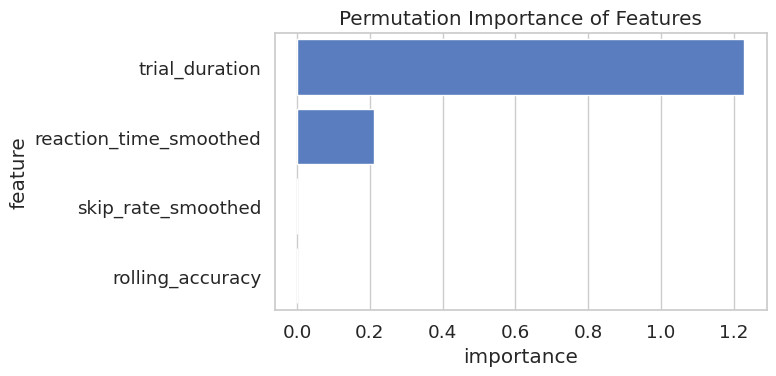

In [172]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()

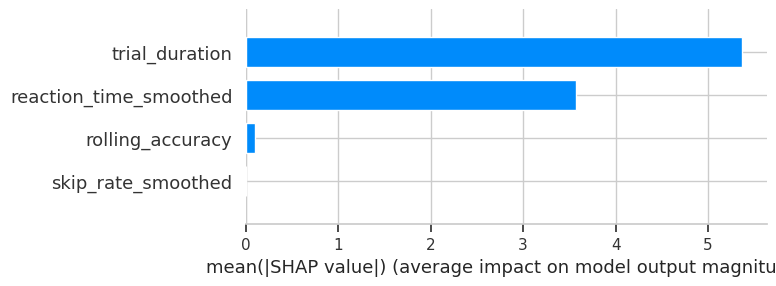

In [173]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

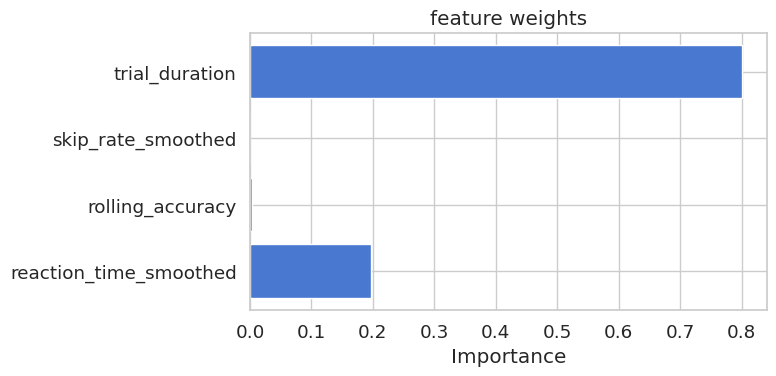

In [174]:
importances = rf.feature_importances_
plt.figure(figsize=(8, 4))
plt.barh(feature_cols, importances)
plt.title("feature weights")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [175]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
# Define high vs. low boredom states
# Define feature matrix (X) and target vector (y)
X = df_all_sess_norm[feature_cols]
y = df_all_sess_norm[target_col]
threshold = y.median()
df_all_sess_norm['boredom_class'] = (df_all_sess_norm['boredom_score'] > threshold).astype(int)  # 1 = high, 0 = low
# Classification model inputs
X_cls = df_all_sess_norm[feature_cols]
y_cls = df_all_sess_norm['boredom_class']
# Train/test split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_cls, y_train_cls)
y_pred_cls = clf.predict(X_test_cls)
# Evaluation
print("Classification Report:\n", classification_report(y_test_cls, y_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        48

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87

Confusion Matrix:
 [[39  0]
 [ 0 48]]


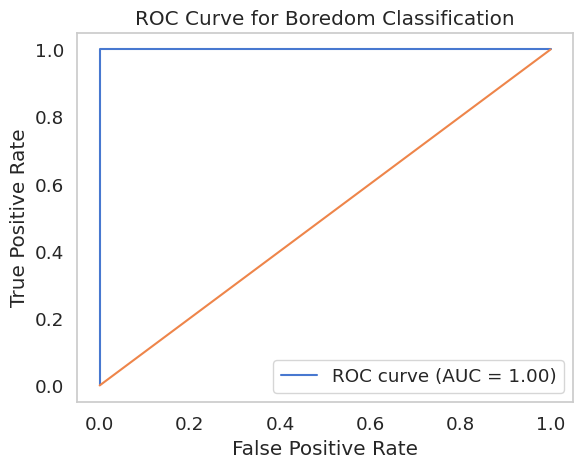

In [179]:
from sklearn.metrics import roc_curve, auc
y_probs = clf.predict_proba(X_test_cls)[:, 1]
fpr, tpr, _ = roc_curve(y_test_cls, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Boredom Classification")
plt.legend()
plt.grid()
plt.show()


# Necessary Plots

Using this data we can plot the psychometric curve and compute some performance metrics, for example the number of trials in the session or the performance of the mouse on easy trials (50% and 100% contrast)

Number of trials for session a4f7079b-d157-4de9-ba80-de9a98f35c8b: 435
Performance easy for session a4f7079b-d157-4de9-ba80-de9a98f35c8b: 0.8295454545454546


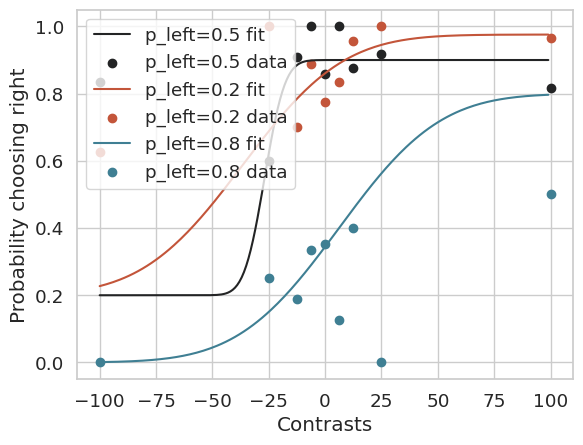

In [146]:
from brainbox.behavior.training import plot_psychometric, compute_n_trials, compute_performance_easy, compute_performance

plot_psychometric(trials)
n_trials = compute_n_trials(trials)
perf_easy = compute_performance_easy(trials)
print(f'Number of trials for session {sess}: {n_trials}')
print(f'Performance easy for session {sess}: {perf_easy}')